## Cornflakes Indentity Operators

First, we need to make a few trivial operators in the cornflakes DSL. We'll be using the tensorflow DSL, but unfortunately there's no easy way to generate the C-structure for kernels in cornflakes.

In [1]:
import popcorn as pc
Vol_2Vec = pc.DofSpace(2,0,1)
Vol_4Vec = pc.DofSpace(4,0,1)
i_R = pc.Input('iR',Vol_2Vec)
i_K = pc.Input('iK',Vol_4Vec)
o_R = pc.Output('R',(Vol_2Vec,),1)
o_K = pc.Output('K',(Vol_2Vec,),2)
ke = pc.Kernel('idty_R',listing=[
    pc.Asgn(o_R,i_R),
])
ke = pc.Kernel('idty_RK',listing=[
    pc.Asgn(o_R,i_R),
    pc.Asgn(o_K,i_K.reshape(2,2)),

])
pc.Husk('identity')

In [2]:
pc.DofSpace?

Init signature: pc.DofSpace(gdim, v_start=0, v_end=l_edge, v_stride=1)
Docstring:      <no docstring>
File:           ~/Documents/Research/opt/lblmeta_python3/lib/python3.7/site-packages/popcorn-1.0-py3.7.egg/popcorn/DofSpace.py
Type:           type


In [1]:
import husk_identity

In [2]:
from eoshub import EOSHub

{'water_linear': '/Users/afq/Google Drive/networks/', 'water_iapws_rh_lg': '/Users/afq/Documents/Research/LBNL/eoshub/eoshub/networks/', 'water_iapws_lg': '/Users/afq/Google Drive/networks/', 'water_slgc': '/Users/afq/Google Drive/networks/', 'water_iapws_slgc_logp_comp': '/Users/afq/Google Drive/networks/'}


In [3]:
eos = 'water_iapws_slgc_logp_comp'
network = 'Classifying_pT_0.0_2,6,24,48,sigmoid,0.05'
ls = EOSHub.LatentSim(eos,network)

In [4]:
import cornflakes as cf
import numpy as np
from matplotlib import pylab as plt

Set up the computation graph with cornflakes

In [5]:
Ny = 10
L = 1
X = np.linspace(0,Ny,10)
H_vol = cf.Hypergraph()
for i in range(Ny):
    H_vol.Push_Edge([i])
H_face = cf.Hypergraph()
for i in range(Ny-1):
    H_face.Push_Edge([i,i+1])

Define the cornflakes data and dofmap structures

In [6]:
q = np.zeros(2*Ny)
dm_q = cf.Dofmap(2,0,2)
dm_4 = cf.Dofmap(4,0,4)
data = {'q':(q,dm_q)}

In [7]:
K_all,R_all = ls._sess.run([ls.K_lhs,ls.lhs], feed_dict ={ls.i_q:q.reshape(-1,2)})

In [8]:
K_all, R_all

(array([[[-7.54296140e+02,  5.46886207e+02],
         [ 5.30786152e+08,  6.36820955e+08]],
 
        [[-7.54296140e+02,  5.46886207e+02],
         [ 5.30786152e+08,  6.36820955e+08]],
 
        [[-7.54296140e+02,  5.46886207e+02],
         [ 5.30786152e+08,  6.36820955e+08]],
 
        [[-7.54296140e+02,  5.46886207e+02],
         [ 5.30786152e+08,  6.36820955e+08]],
 
        [[-7.54296140e+02,  5.46886207e+02],
         [ 5.30786152e+08,  6.36820955e+08]],
 
        [[-7.54296140e+02,  5.46886207e+02],
         [ 5.30786152e+08,  6.36820955e+08]],
 
        [[-7.54296140e+02,  5.46886207e+02],
         [ 5.30786152e+08,  6.36820955e+08]],
 
        [[-7.54296140e+02,  5.46886207e+02],
         [ 5.30786152e+08,  6.36820955e+08]],
 
        [[-7.54296140e+02,  5.46886207e+02],
         [ 5.30786152e+08,  6.36820955e+08]],
 
        [[-7.54296140e+02,  5.46886207e+02],
         [ 5.30786152e+08,  6.36820955e+08]]]),
 array([[6.36222792e+02, 2.25330037e+08],
        [6.36222792e+02, 2.2

In [9]:
dm_4.Get(1)

array([4, 5, 6, 7], dtype=int32)

In [10]:
K_all

array([[[-7.54296140e+02,  5.46886207e+02],
        [ 5.30786152e+08,  6.36820955e+08]],

       [[-7.54296140e+02,  5.46886207e+02],
        [ 5.30786152e+08,  6.36820955e+08]],

       [[-7.54296140e+02,  5.46886207e+02],
        [ 5.30786152e+08,  6.36820955e+08]],

       [[-7.54296140e+02,  5.46886207e+02],
        [ 5.30786152e+08,  6.36820955e+08]],

       [[-7.54296140e+02,  5.46886207e+02],
        [ 5.30786152e+08,  6.36820955e+08]],

       [[-7.54296140e+02,  5.46886207e+02],
        [ 5.30786152e+08,  6.36820955e+08]],

       [[-7.54296140e+02,  5.46886207e+02],
        [ 5.30786152e+08,  6.36820955e+08]],

       [[-7.54296140e+02,  5.46886207e+02],
        [ 5.30786152e+08,  6.36820955e+08]],

       [[-7.54296140e+02,  5.46886207e+02],
        [ 5.30786152e+08,  6.36820955e+08]],

       [[-7.54296140e+02,  5.46886207e+02],
        [ 5.30786152e+08,  6.36820955e+08]]])

In [12]:
for e in H_vol:
    print(cf.Collect(husk_identity.kernel_idty_RK,e, {'iR':(R_all,dm_q),'iK':(K_all.flatten(),dm_4)}))

[-7.54296140e+02  5.46886207e+02  5.30786152e+08  6.36820955e+08
  6.36222792e+02  2.25330037e+08]
[-7.54296140e+02  5.46886207e+02  5.30786152e+08  6.36820955e+08
  6.36222792e+02  2.25330037e+08]
[-7.54296140e+02  5.46886207e+02  5.30786152e+08  6.36820955e+08
  6.36222792e+02  2.25330037e+08]
[-7.54296140e+02  5.46886207e+02  5.30786152e+08  6.36820955e+08
  6.36222792e+02  2.25330037e+08]
[-7.54296140e+02  5.46886207e+02  5.30786152e+08  6.36820955e+08
  6.36222792e+02  2.25330037e+08]
[-7.54296140e+02  5.46886207e+02  5.30786152e+08  6.36820955e+08
  6.36222792e+02  2.25330037e+08]
[-7.54296140e+02  5.46886207e+02  5.30786152e+08  6.36820955e+08
  6.36222792e+02  2.25330037e+08]
[-7.54296140e+02  5.46886207e+02  5.30786152e+08  6.36820955e+08
  6.36222792e+02  2.25330037e+08]
[-7.54296140e+02  5.46886207e+02  5.30786152e+08  6.36820955e+08
  6.36222792e+02  2.25330037e+08]
[-7.54296140e+02  5.46886207e+02  5.30786152e+08  6.36820955e+08
  6.36222792e+02  2.25330037e+08]


In [14]:
K_all,R_all = ls._sess.run([ls.K_lhs,ls.lhs], feed_dict ={ls.i_q:q.reshape(-1,2)})
R,K = cf.Assemble(husk_identity.kernel_idty_RK,
            H_vol,
            {'iR':(R_all,dm_q),'iK':(K_all,dm_4)},
            {'R':(dm_q,),'K':(dm_q,)},ndof=Ny*2)

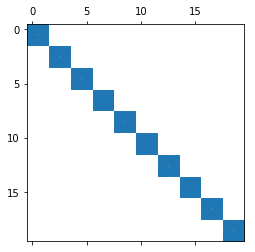

In [16]:
plt.spy(K)

In [ ]:
for e in H_vol:
    ii = dm_q.Get_List(e)
    _q = q[ii]
    print(_q)

In [9]:
rho0,T0 = 200,500
q0 = ls.find_point(rho=rho0,T=T0)
for e in H_vol:
    q[dm_q.Get_List(e)] = q0
    

In [22]:
def plot(q):
    s = ls.decode(q.reshape(-1,2))
    for i,leg in enumerate(['T','P','rho','rho*h']):
        plt.subplot(1,4,i+1)
        plt.plot(s[:,i],X)
        plt.xlabel(leg)
    plt.tight_layout()
    plt.show()

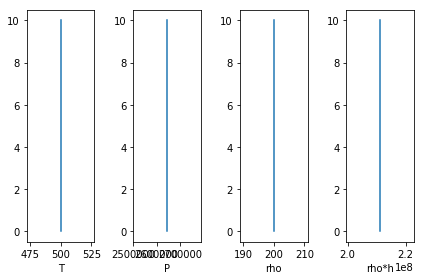

In [23]:
plot(q)

# scratch

In [19]:
X = cf.ParticlePlacers.init_grid(Nx=5,Ny=5,start=[0,0],e1=[L,0],e2=[0,L])
H = cf.Graphers.Build_Pair_Graph(X,cutoff=0.12)

In [21]:
H.view()

[array([[ 0,  2],
        [ 1,  3],
        [ 2,  4],
        [ 3,  5],
        [ 4,  6],
        [ 5,  7],
        [ 6,  8],
        [ 7,  9],
        [ 8, 10],
        [ 9, 11],
        [10, 12],
        [11, 13],
        [14, 12],
        [14, 16],
        [15, 13],
        [15, 17],
        [16, 18],
        [17, 19]], dtype=int32)]

In [29]:
for e in H:
    plt.plot(X[:,e[0]],X[:,e[1]])
plt.show()

IndexError: too many indices for array